In [1]:
from itertools import combinations, permutations, product
from pathlib import Path

import duckdb
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
import pygwalker as pyg
import seaborn as sns
import srsly
from matplotlib import ticker
from tqdm.auto import tqdm

In [2]:
pl.Config.set_fmt_str_lengths(100)
con = duckdb.connect()

In [5]:
hparams = []

for p in tqdm(list(Path("../outputs/submitted_results").rglob("*/*/tb_logs.parquet"))):
    meta = srsly.read_yaml(p.parent / "hparams.yaml")
    hparams.append(
        dict(
            strategy=p.parents[0].name.split("_")[0],
            filename=str(p),
            data_seed=meta["data"]["seed"],
            model_seed=meta["model"]["seed"],
            seed=f'{meta["data"]["seed"]}-{meta["model"]["seed"]}',
            group=p.parents[2].name,
            num_anchors=meta["strategy"].get("num_anchors", None),
            subset_size=meta["strategy"].get("subset_size", None),
            num_neighbours=meta["strategy"].get("num_neighbours", None),
            anchor_strategy=meta["strategy"].get("anchor_strategy", None),
            positive_budget=meta["active_data"].get("positive_budget", None),
            retriever=meta["index_metric"],
            dataset=meta["dataset"]["short_name"],
        )
    )

hparams_df = pd.DataFrame(hparams)

  0%|          | 0/877 [00:00<?, ?it/s]

In [6]:
count_query = """
SELECT tag, count(tag)
FROM read_parquet('../outputs/submitted_results/*/*/*/tb_logs.parquet', filename=True)
GROUP BY tag
"""
metrics = con.execute(count_query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
metrics.query("tag.str.startswith('summary')")

,tag,count(tag)
43,summary/count_class_0,62420
44,summary/count_class_1,62420
45,summary/cumulative_count_class_0,63297
46,summary/cumulative_count_class_1,63297
47,summary/cumulative_minority_ratio,63297
48,summary/labelled_size,63297
49,summary/minority_ratio,62420
50,summary/pool_size,63297
116,summary/ids_retrieved,45820
117,summary/subset_size,54220


In [9]:
count_query = """
SELECT *
FROM read_parquet('../outputs/submitted_results/*/*/*/tb_logs.parquet', filename=True)
WHERE tag IN (
    'test/f1_class1_vs_budget',
    'test/loss',
    'summary/unique_ids_retrieved',
    'summary/count_class_1',
)
"""

all_df = con.execute(count_query).df()

In [10]:
df = pd.merge(all_df, hparams_df, on="filename", how="left")
assert df["group"].isna().sum() == 0

In [11]:
mapper = {
    "random": "Random",
    "randomsubset": "RandomSubset",
    "all": "AnchorAL",
    "all-anchorssubset-min": "SEALS",
}

df = df.loc[df["strategy"].isin(mapper)].assign(
    strategy_name=lambda _df: _df["strategy"].map(mapper)
)

In [12]:
df["strategy_name"].value_counts()

strategy_name
AnchorAL        121844
SEALS            33366
RandomSubset     25368
Random           24764
Name: count, dtype: int64

---
Comparisons

In [17]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.style.use("bmh")
sns.set_context("paper")
plt.ion()
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]

/tmp/ipykernel_763848/1495582146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["id"] = (


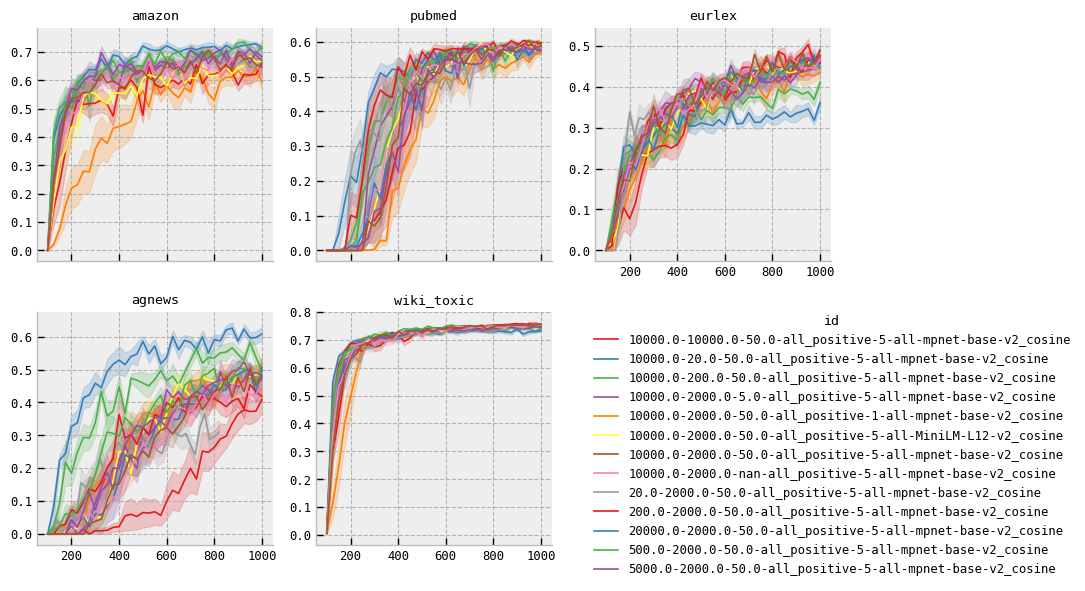

In [21]:
plot_data = df.loc[
    (df["tag"].isin(["test/f1_class1_vs_budget"])) 
    & (df["strategy_name"] == "AnchorAL")
    & (df["step"] <= 1000)
]

plot_data["id"] = (
    plot_data["subset_size"].astype(str) 
    + "-" + plot_data["num_neighbours"].astype(str)
    + "-" + plot_data["num_anchors"].astype(str)
    + "-" + plot_data["anchor_strategy"]
    + "-" + plot_data["positive_budget"].astype(int).astype(str)
    + "-" + plot_data["retriever"]
)
 
hue_col = "id"
legend_order = sorted(plot_data[hue_col].unique().tolist())
palette = dict(zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order))))

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    # xlim=(0, xlim),
    # ylim=ylim,
    sharey=False,
    col_order=col_order,
)
g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue=hue_col,
    palette=palette,
)
g.tight_layout()
g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)
g.add_legend(
    label_order=legend_order, bbox_to_anchor=(0.82, 0.25), title=hue_col
)

In [30]:
plot_data["auc"] = plot_data.groupby("filename")["value"].transform(np.trapz)

/tmp/ipykernel_763848/2377813786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["auc"] = plot_data.groupby("filename")["value"].transform(np.trapz)


In [46]:
dims = [
    "auc",
    "subset_size",
    "num_neighbours",
    "num_anchors",
    "positive_budget",
    "anchor_strategy",
    "retriever",
]
p = plot_data.groupby("id")[dims].agg(
    auc=("auc", "mean"),
    subset_size=("subset_size", "mean"),
    num_neighbours=("num_neighbours", "mean"),
    num_anchors=("num_anchors", "mean"),
    positive_budget=("positive_budget", "mean"),
    anchor_strategy=("anchor_strategy", lambda ex: list(set(ex))[0]),
    retriever=("retriever", lambda ex: list(set(ex))[0]),
)

In [47]:
p

,auc,subset_size,num_neighbours,num_anchors,positive_budget,anchor_strategy,retriever
id,,,,,,,
10000.0-10000.0-50.0-all_positive-5-all-mpnet-base-v2_cosine,14.832178,10000.0,10000.0,50.0,5.0,all_positive,all-mpnet-base-v2_cosine
10000.0-20.0-50.0-all_positive-5-all-mpnet-base-v2_cosine,18.936647,10000.0,20.0,50.0,5.0,all_positive,all-mpnet-base-v2_cosine
10000.0-200.0-50.0-all_positive-5-all-mpnet-base-v2_cosine,18.012108,10000.0,200.0,50.0,5.0,all_positive,all-mpnet-base-v2_cosine
10000.0-2000.0-5.0-all_positive-5-all-mpnet-base-v2_cosine,16.762996,10000.0,2000.0,5.0,5.0,all_positive,all-mpnet-base-v2_cosine
10000.0-2000.0-50.0-all_positive-1-all-mpnet-base-v2_cosine,15.167733,10000.0,2000.0,50.0,1.0,all_positive,all-mpnet-base-v2_cosine
10000.0-2000.0-50.0-all_positive-5-all-MiniLM-L12-v2_cosine,16.425877,10000.0,2000.0,50.0,5.0,all_positive,all-MiniLM-L12-v2_cosine
10000.0-2000.0-50.0-all_positive-5-all-mpnet-base-v2_cosine,16.505011,10000.0,2000.0,50.0,5.0,all_positive,all-mpnet-base-v2_cosine
10000.0-2000.0-nan-all_positive-5-all-mpnet-base-v2_cosine,16.388978,10000.0,2000.0,NaN,5.0,all_positive,all-mpnet-base-v2_cosine
20.0-2000.0-50.0-all_positive-5-all-mpnet-base-v2_cosine,14.462755,20.0,2000.0,50.0,5.0,all_positive,all-mpnet-base-v2_cosine


In [82]:
import plotly.express as px

fig = px.parallel_coordinates(
    plot_data, 
    color="auc", 
    dimensions=[
        "auc",
        # "subset_size",
        "num_neighbours",
        # "num_anchors",
        # "anchor_strategy",
        # "positive_budget",
        # "retriever",
    ],
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=15,
)
fig.show()


In [56]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
dims = [
    "auc",
    "subset_size",
    "num_neighbours",
    "num_anchors",
    "positive_budget",
    # "anchor_strategy",
    "retriever",
]
c = plot_data[dims]
c["retriever"] = c["retriever"] == "all-mpnet-base-v2_cosine"
c["num_anchors"] = c["num_anchors"].fillna(100000)

/tmp/ipykernel_763848/3019538697.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_763848/3019538697.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



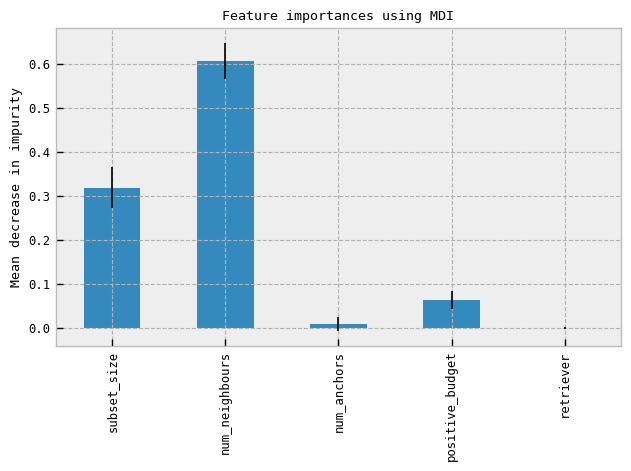

In [69]:
reg = RandomForestRegressor()
reg.fit(c[dims[1:]], c[dims[0]])

importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)

forest_importances = pd.Series(importances, index=dims[1:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

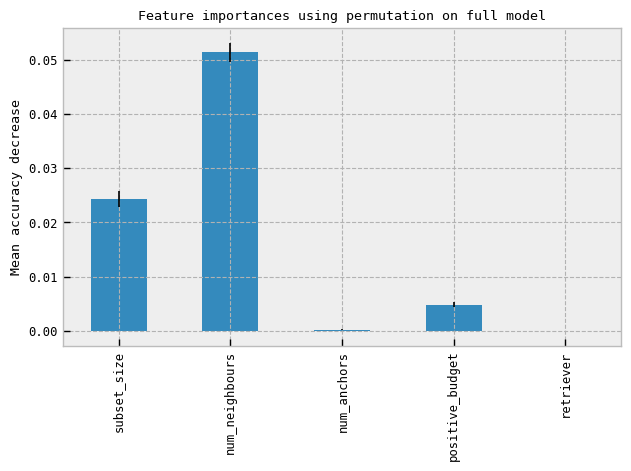

In [70]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    reg, c[dims[1:]], c[dims[0]], n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=dims[1:])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [80]:
plot_data[dims][["num_neighbours", "auc"]].corr()

,num_neighbours,auc
num_neighbours,1.000000,-0.118331
auc,-0.118331,1.000000


In [10]:
ddf = df.query("strategy_name == 'AnchorAL'").assign(
    num_anchors=lambda _df: _df["num_anchors"]
    .fillna("0")
    .astype(int)
    .astype(str)
    .replace("0", "All")
)

---
### Plots

In [12]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.style.use("bmh")
sns.set_context("paper")
plt.ion()
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]

In [17]:
def plot(
    plot_data,
    hue_col,
    col_order=col_order,
    palette=None,
    legend_order=None,
    xlim=1_000,
) -> None:

    g = sns.FacetGrid(
        plot_data,
        col="dataset",
        col_wrap=3,
        sharex=True,
        legend_out=True,
        despine=True,
        xlim=(0, xlim),
        # ylim=ylim,
        sharey=False,
        col_order=col_order,
    )
    g.map_dataframe(
        sns.lineplot,
        data=plot_data,
        x="step",
        y="value",
        errorbar=("se", 1),
        hue=hue_col,
        palette=palette,
    )
    g.tight_layout()
    g.set_axis_labels("", "")
    g.set_titles(
        col_template="{col_name}",
    )
    g.add_legend(
        label_order=legend_order, bbox_to_anchor=(0.82, 0.25), title=hue_col
    )
    # plt.savefig(fname=f"p.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
    return g

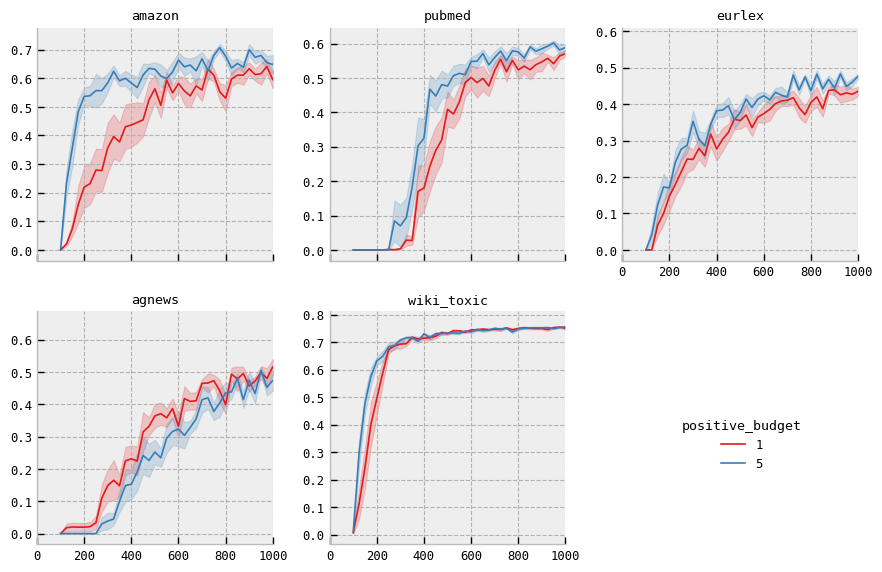

In [14]:
metric = "test/f1_class1_vs_budget"
hue_col = "positive_budget"

plot_data = ddf.loc[
    (ddf["group"].isin(["seeds", "initial_set"])) & (ddf["tag"] == metric)
].assign(positive_budget=lambda _df: _df["positive_budget"].astype(str))

legend_order = sorted(plot_data[hue_col].unique().tolist())
palette = dict(
    zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order)))
)

plot(plot_data, hue_col=hue_col, palette=palette, legend_order=legend_order)

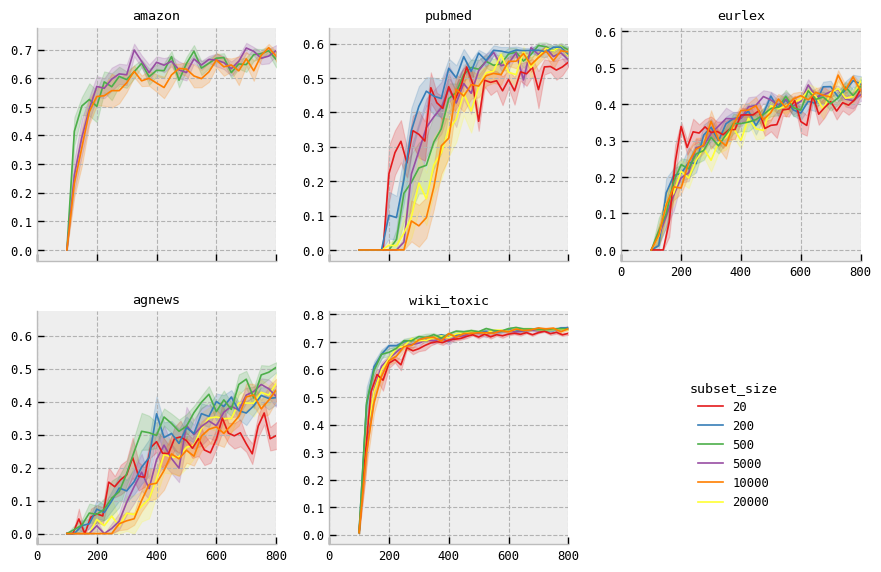

In [20]:
metric = "test/f1_class1_vs_budget"
hue_col = "subset_size"

plot_data = ddf.loc[
    (ddf["group"].isin(["seeds", hue_col])) & (ddf["tag"] == metric)
].assign(**{hue_col: lambda _df: _df[hue_col].astype(int).astype(str)})

legend_order = sorted(plot_data[hue_col].unique().tolist(), key=lambda ex: int(ex))
palette = dict(
    zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order)))
)

fig = plot(
    plot_data, hue_col=hue_col, palette=palette, legend_order=legend_order, xlim=800
)

In [27]:
plot_data = (
    ddf.loc[(ddf["group"].isin(["seeds", hue_col])) & (ddf["tag"] == metric)]
    .assign(**{hue_col: lambda _df: _df[hue_col].astype(int).astype(str)})
    .filter(["dataset", "step", "value", hue_col])
    .groupby(["dataset", hue_col, "step"])
    .agg(["mean", "std"])
    .stack(0)
    .reset_index()
    .drop(columns="level_3")
)

In [28]:
plot_data

,dataset,subset_size,step,mean,std
0,agnews,10000,100,0.000000,0.000000
1,agnews,10000,125,0.000000,0.000000
2,agnews,10000,150,0.000000,0.000000
3,agnews,10000,175,0.000000,0.000000
4,agnews,10000,200,0.000000,0.000000
...,...,...,...,...,...
1314,wiki_toxic,5000,900,0.747227,0.011072
1315,wiki_toxic,5000,925,0.753063,0.010593
1316,wiki_toxic,5000,950,0.754851,0.009711
1317,wiki_toxic,5000,975,0.753566,0.010458


In [32]:
fig = px.line(
    plot_data,
    x="step",
    y="mean",
    color="subset_size",
    facet_col="dataset",
    facet_col_wrap=3,
)
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
def f(s) -> str:
    return (
        r"\floatpm[2]{" + s.mean().astype(str) + r"}{" + s.std().astype(str) + r"}"
    )


def load_from_folder(path: Path, metrics: list[str]) -> pl.DataFrame:

    path = Path(path)
    list_df = []

    for p in tqdm(list(path.rglob("*tb_logs.parquet"))):
        strategy = p.parents[0].name.split("_")[0]
        dataset = p.parents[1].name

        meta = srsly.read_yaml(p.parent / "hparams.yaml")

        df = (
            pl.scan_parquet(p)
            # .filter(pl.col("tag").is_in(metrics))
            .with_columns(
                strategy=pl.lit(strategy),
                dataset=pl.lit(dataset),
                path=pl.lit(p.parent.name),
                data_seed=meta["data"]["seed"],
                model_seed=meta["model"]["seed"],
                seed=pl.lit(f'{meta["data"]["seed"]}-{meta["model"]["seed"]}'),
                group=p.parents[2].name,
                num_anchors=meta["strategy"].get("num_anchors", None),
                subset_size=meta["strategy"].get("subset_size", None),
                num_neighbours=meta["strategy"].get("num_neighbours", None),
                anchor_strategy=meta["strategy"].get("anchor_strategy", None),
                positive_budget=meta["active_data"].get("positive_budget", None),
                retriever=meta["index_metric"],
            )
        )

        list_df.append(df)

    return (
        pl.concat(list_df)
        # .groupby(["strategy", "dataset", "step"])
        # .agg(mean=pl.col("value").mean(), std=pl.col("value").std(), n=pl.count("value"))
        .collect(streaming=True)
    )

In [ ]:
df = load_from_folder("../outputs/multirun", None)

In [ ]:
pd.read_parquet(
    "../outputs/multirun/initial_set/agnews/random_2023-06-22T21-37-04_active_train_59/tb_logs.parquet"
)

In [ ]:
dd = df.collect(streaming=True)

In [ ]:
anchor_strategy_path = Path("../outputs/multirun/anchor_strategy/")
initial_set_path = Path("../outputs/multirun/initial_set/")
num_anchors_path = Path("../outputs/multirun/num_anchors/")
retriever_path = Path("../outputs/multirun/retriever/")
seeds_path = Path("../outputs/multirun/seeds/")
subset_size_path = Path("../outputs/multirun/subset_size/")

In [ ]:
metrics = [
    "test/f1_class1_vs_budget",
    "summary/count_class_1",
    "summary/ids_retrieved",
    "summary/unique_ids_retrieved",
    "summary/subset_size",
]

In [ ]:
anchor_strategy_df = load_from_folder(anchor_strategy_path, metrics)
initial_set_df = load_from_folder(initial_set_path, metrics)
num_anchors_df = load_from_folder(num_anchors_path, metrics)
retriever_df = load_from_folder(retriever_path, metrics)
seeds_df = load_from_folder(seeds_path, metrics)
subset_size_df = load_from_folder(subset_size_path, metrics)

In [ ]:
mapper = {
    "random": "Random",
    "randomsubset": "RandomSubset",
    "all": "AnchorAL",
    "all-anchorssubset-min": "SEALS",
}

anchor_strategy_df = anchor_strategy_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
initial_set_df = initial_set_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
num_anchors_df = num_anchors_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
retriever_df = retriever_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
seeds_df = seeds_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper))
subset_size_df = subset_size_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)

In [ ]:
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]
strategy_order = sorted(seeds_df["strategy_name"].unique())

In [ ]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.rcParams["font.size"] = 18
# plt.rcParams["axes.linewidth"] = 2
plt.style.use("bmh")
sns.set_context("paper")

# sorted(matplotlib.font_manager.get_font_names())

In [ ]:
palette = dict(
    zip(strategy_order, sns.color_palette("Set1", n_colors=len(strategy_order)))
)


def plot(
    plot_data: pd.DataFrame,
    palette=palette,
    xlim=(0, None),
    ylim=(-0.001, None),
    col_order=col_order,
    strategy_order=strategy_order,
    filename=None,
) -> None:
    g = sns.FacetGrid(
        plot_data,
        col="dataset",
        col_wrap=3,
        sharex=True,
        legend_out=True,
        despine=True,
        xlim=xlim,
        ylim=ylim,
        sharey=False,
        col_order=col_order,
    )

    g.tight_layout()

    g.map_dataframe(
        sns.lineplot,
        data=plot_data,
        x="step",
        y="value",
        errorbar=("se", 1),
        hue="strategy_name",
        palette=palette,
    )

    g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if xlim[1] == 2600 else 0.6)
    g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if xlim[1] == 2600 else 0.65)
    g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if xlim[1] == 2600 else 0.55)
    g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
    g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if xlim[1] == 2600 else 0.75)

    g.set_axis_labels("", "")
    g.set_titles(
        col_template="{col_name}",
    )
    g.add_legend(label_order=strategy_order, bbox_to_anchor=(0.82, 0.25))
    # g.despine()
    if filename:
        plt.savefig(
            fname=f"{filename}.png",
            dpi=1000,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )
    plt.show()

---
### checks

In [ ]:
check_df = anchor_strategy_df

In [ ]:
check_df["strategy"].unique().to_list()

In [ ]:
check_df["dataset"].unique().to_list()
assert check_df["dataset"].nunique() == len(col_order)

In [ ]:
check_df.groupby(["dataset", "strategy"]).agg(pl.col("path").n_unique()).sort(
    ["strategy"]
).filter(pl.col("path") < 9)

In [ ]:
seeds_df.filter(
    (pl.col("dataset") == "amazon") & (pl.col("strategy") == "all-anchorssubset-min")
)["seed"].value_counts()

In [ ]:
seeds_df.filter(
    (pl.col("dataset") == "wiki_toxic")
    & (pl.col("strategy") == "all-anchorssubset-min")
).groupby(["seed", "path"]).agg(pl.col("value").mean()).sort(pl.col("seed"))

In [ ]:
done = set(
    seeds_df.filter(
        (pl.col("dataset") == "wiki_toxic")
        & (pl.col("strategy") == "all-anchorssubset-min")
    )["seed"].unique()
)
total = set(f"{i}-{j}" for i, j in product([42, 0, 1994], [42, 0, 1994]))
total.difference(done)

---
### Learning curves

In [ ]:
plot_data = seeds_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()

In [ ]:
plot(plot_data, palette, xlim=(0, 2600), filename="img_learning_curves_2600")

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "Strategy"])[["auc_1000", "auc"]]
    .agg(f)
    .to_latex()
)

In [ ]:
print(metrics[1])
plot_data = (
    seeds_df.filter(
        (pl.col("strategy_name").is_in(mapper.values()))
        & (pl.col("tag") == metrics[1])
    )
    .to_pandas()
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

In [ ]:
strategies = sorted(plot_data["strategy_name"].unique())
palette = dict(zip(strategies, sns.color_palette("Set1", n_colors=len(strategies))))
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    # ylim=(-.001,None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="strategy_name",
    palette=palette,
)

# g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(label_order=strategies, bbox_to_anchor=(0.82, 0.25))
# g.despine()
# plt.savefig(fname=f"learning_curves_{ymax}.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
def _f(_df):
    return (
        r"\floatpm[0]{"
        + _df["mean"].astype(str)
        + r"}{"
        + _df["std"].astype(str)
        + r"}"
    )


print(
    plot_data.query("step <= 1000")
    .assign(
        strategy_name=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
    )
    .groupby(["strategy_name", "dataset", "path"])["value"]
    .agg("sum")
    .reset_index()
    .groupby(["dataset", "strategy_name"])["value"]
    .agg(["mean", "std"])
    .assign(
        ratio=lambda _df: _df.groupby("dataset")["mean"].transform("max")
        / _df["mean"],
        latex=lambda _df: _df.apply(_f, axis=1),
    )
    .assign(latex_ratio=lambda _df: r"\float[2]{" + _df["ratio"].astype(str) + "}")
    .filter(["latex", "latex_ratio"])
    .to_latex()
    # .groupby("strategy_name")["ratio"].mean()
)

In [ ]:
a["ratio"] = a["mean"].max() / a["mean"]

In [ ]:
print(a.apply(f, axis=1).to_frame().join(a["ratio"].to_frame()).to_latex())

---

### Effect of the seed set

In [ ]:
plot_data = initial_set_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()

In [ ]:
plot(
    plot_data,
    palette,
    xlim=(0, 1000),
    filename="img_learning_curves_1000_initial_set",
)

In [ ]:
plot_data = pl.concat(
    [
        seeds_df.filter(
            (
                pl.col("strategy_name").is_in(
                    initial_set_df["strategy_name"].unique().to_list()
                )
            )
            & (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(n_positive=5),
        initial_set_df.filter(
            (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(n_positive=1),
    ]
).to_pandas()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data.loc[plot_data["strategy_name"] == "AnchorAL"],
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="n_positive",
    palette=dict(zip([5, 1], sns.color_palette("Set1", n_colors=2))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. minority in seed set")
plt.savefig(
    fname=f"img_num_minority_seed_set.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "Strategy", "n_positive"])[["auc_1000", "auc"]]
    .agg(f)
    .unstack(2)
    # .to_latex()
)

In [ ]:
# (
#    plot_data
#     .assign(
#         auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
#         auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
#     )
#     .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)
#     # .to_latex()
# )

In [ ]:
# plot_data = pl.concat(
#     [
#         seeds_df.filter(
#             (pl.col("strategy_name").is_in(initial_df["strategy_name"].unique().to_list()))
#             & (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(n_positive=5),
#         initial_df.filter(
#             (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1),
#     ]
# ).to_pandas().assign(step=lambda _df: (_df["step"] * 25) + 100)

In [ ]:
# ymax = 2600

# g = sns.FacetGrid(
#     plot_data,
#     col="dataset",
#     col_wrap=3,
#     sharex=True,
#     legend_out=True,
#     despine=True,
#     # xlim=(0, ymax),
#     # ylim=(-.001,None),
#     sharey=False,
#     col_order=col_order,
# )

# g.tight_layout()

# g.map_dataframe(
#     sns.lineplot,
#     data=plot_data,
#     x="step",
#     y="value",
#     errorbar=("se", 2),
#     hue="n_positive",
#     palette=dict(zip([5, 1], sns.color_palette("Set1", n_colors=2))),
# )

# # g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# # g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# # g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# # g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# # g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

# g.set_axis_labels("", "")
# g.set_titles(col_template="{col_name}",)

# g.add_legend(bbox_to_anchor=(.79, .25), title="num. minority in seed set")
# # plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
# plt.show()

---
### Effect of the Retriever

In [ ]:
plot_data = pl.concat(
    [
        seeds_df.filter(
            (
                pl.col("strategy_name").is_in(
                    retriever_df["strategy_name"].unique().to_list()
                )
            )
            & (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(retriever=pl.lit("MPNet")),
        retriever_df.filter(
            (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(retriever=pl.lit("MiniLM")),
    ]
).to_pandas()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    # ax=ax,
    hue="retriever",
    palette=dict(zip(["MPNet", "MiniLM"], sns.color_palette("Set1", n_colors=2))),
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="encoder model")
plt.savefig(
    fname=f"img_retriever.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
def g(s) -> str:
    return (
        r"\floatpm[2]{"
        + s["mean"].astype(str)
        + r"}{"
        + np.abs(s["std"]).astype(str)
        + r"}"
    )


(
    plot_data.assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
        dataset=lambda _df: "\\" + _df["dataset"],
        strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
    )
    .groupby(["dataset", "strategy", "retriever"])[["auc", "auc_1000"]]
    .agg(["mean", "std"])
    .stack(0)
    .stack(0)
    .unstack(2)
    .assign(diff=lambda _df: _df["MPNet"] - _df["MiniLM"])
    .unstack(3)
    .stack(0)
    .apply(g, 1)
    .unstack(3)
    .droplevel(1)
    .filter(["MPNet", "MiniLM", "diff"])
    # .to_latex()
)

In [ ]:
# plot_data = pl.concat(
#     [
#         seeds_df.filter(
#             (pl.col("strategy_name").is_in(retriever_df["strategy_name"].unique().to_list()))
#             & (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(retriever=pl.lit("MPNet")),
#         retriever_df.filter(
#             (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(strategy_name=pl.col("strategy").map_dict(mapper), retriever=pl.lit("MiniLM")),
#     ]
# ).to_pandas().assign(step=lambda _df: (_df["step"] * 25) + 100)

In [ ]:
# ymax = 2600

# g = sns.FacetGrid(
#     plot_data,
#     col="dataset",
#     col_wrap=3,
#     sharex=True,
#     legend_out=True,
#     despine=True,
#     # xlim=(0, ymax),
#     # ylim=(-.001,None),
#     sharey=False,
#     col_order=col_order,
# )

# g.tight_layout()

# g.map_dataframe(
#     sns.lineplot,
#     data=plot_data,
#     x="step",
#     y="value",
#     errorbar=("se", 2),
#     hue="retriever",
#     palette=dict(zip(["MPNet", "MiniLM"], sns.color_palette("Set1", n_colors=2))),
# )

# # g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# # g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# # g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# # g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# # g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

# g.set_axis_labels("", "")
# g.set_titles(col_template="{col_name}",)

# g.add_legend(bbox_to_anchor=(.79, .25), title="num. minority in seed set")
# # plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
# plt.show()

---

### Effect of the Anchor Strategy

In [ ]:
plot_data = pd.concat(
    [
        (
            seeds_df.filter(
                pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                & (pl.col("strategy_name").is_in(mapper.values()))
                & (pl.col("tag") == metrics[0])
            )
            .to_pandas()
            .rename(columns={"strategy_name": "anchor_strategy"})
        ),
        (
            anchor_strategy_df.filter(pl.col("tag") == metrics[0])
            .to_pandas()
            .assign(
                anchor_strategy=lambda _df: (
                    _df["path"]
                    .str.split("-", expand=True)[0]
                    .str.strip()
                    .map(
                        {
                            "kmeans": "K-Means (All Labelled)",
                            "random": "Random (All Labelled)",
                        }
                    )
                    .str.title()
                )
            )
        ),
    ]
).reset_index(drop=True)

In [ ]:
plot_data["anchor_strategy"].unique()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="anchor seletion strategy")
plt.savefig(
    fname=f"img_anchor_strategy.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
(
    plot_data.assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["dataset", "anchor_strategy"])[["auc", "auc_1000"]]
    .agg(f)
    # .to_latex()
)

In [ ]:
plot_data = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-1])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-1])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    # xlim=(0, ymax),
    ylim=(5000, 10500),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)

# g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)
# g.set(yscale='log')
g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. minority in seed set")
# plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
metrics

---
### Num anchors

In [ ]:
path = Path("../outputs/multirun/num_anchors/")
h = []
for p in path.rglob("hparams.yaml"):
    n = {
        "path": p.parent.name,
        "num_anchors": srsly.read_yaml(p)["strategy"]["num_anchors"],
    }
    h.append(n)
num = pd.DataFrame(h).fillna("all")

In [ ]:
a = seeds_df.filter(
    (
        pl.col("strategy_name").is_in(
            num_anchors_df["strategy_name"].unique().to_list()
        )
    )
    & (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).with_columns(num_anchors=50)

b = num_anchors_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()
c = pd.merge(b, num, on="path", how="inner")
assert len(c) == len(b)

In [ ]:
plot_data = pd.concat([a.to_pandas(), c]).reset_index()
plot_data["num_anchors"] = (
    plot_data["num_anchors"]
    .astype(str)
    .map({"50": "50", "all": "all labelled set", "5.0": "5 (default)"})
)

In [ ]:
plot_data["num_anchors"].unique()

In [ ]:
ymax = 1000
l = sorted(plot_data["num_anchors"].unique().tolist())

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="num_anchors",
    palette=dict(zip(l, sns.color_palette("Set1", n_colors=len(l)))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. anchors")
plt.savefig(
    fname=f"img_num_anchors.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        # auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "num_anchors"])[["auc_1000"]]
    .agg(f)
    .unstack(1)
    .to_latex()
)

---
### Subset Size

In [ ]:
path = Path("../outputs/multirun/subset_size/")
h = []
for p in path.rglob("hparams.yaml"):
    n = {
        "path": p.parent.name,
        "subset_size": srsly.read_yaml(p)["strategy"]["subset_size"],
    }
    h.append(n)
num = pd.DataFrame(h).fillna("all")

In [ ]:
a = seeds_df.filter(
    (
        pl.col("strategy_name").is_in(
            subset_size_df["strategy_name"].unique().to_list()
        )
    )
    & (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).with_columns(subset_size=10000)

b = subset_size_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()
c = pd.merge(b, num, on="path", how="inner")
assert len(c) == len(b)

In [ ]:
plot_data = pd.concat([a.to_pandas(), c]).reset_index()
plot_data.groupby(["dataset", "strategy"])["subset_size"].value_counts()

In [ ]:
ymax = 1000
l = sorted(plot_data["subset_size"].unique().tolist())

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="subset_size",
    palette=dict(zip(l, sns.color_palette("Set1", n_colors=len(l)))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="subset size")
plt.savefig(
    fname=f"img_subset_size.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        # auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "subset_size"])[["auc_1000"]]
    .agg(f)
    .unstack(1)
    .to_latex()
)

---
### AUC

In [ ]:
table_data = pl.concat(
    [
        seeds_df.filter(
            pl.col("strategy_name").is_in(
                initial_df["strategy_name"].unique().to_list()
            )
        ).with_columns(n_positive=5),
        initial_df.with_columns(
            strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1
        ),
    ]
)

print(
    table_data.to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]]
    .agg(f)
    .to_latex()
)

In [ ]:
def g(s) -> str:
    return (
        r"\floatpm[2]{"
        + s["mean"].astype(str)
        + r"}{"
        + np.abs(s["std"]).astype(str)
        + r"}"
    )


(
    table_data.to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
        dataset=lambda _df: "\\" + _df["dataset"],
        strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
    )
    .groupby(["dataset", "strategy", "n_positive"])[["auc", "auc_1000"]]
    .agg(["mean", "std"])
    .stack(0)
    .stack(0)
    .unstack(2)
    .assign(diff=lambda _df: _df[5] - _df[1])
    .unstack(3)
    .stack(0)
    .apply(g, 1)
    .unstack(3)
    # .to_latex()
)

In [ ]:
 table_data
   .to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)

In [ ]:
a = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-1])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-1])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

b = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-2])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-2])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

c = pd.concat(
    [
        (
            seeds_df.filter(
                pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                & (pl.col("strategy_name").is_in(mapper.values()))
                & (pl.col("tag") == metrics[0])
            )
            .to_pandas()
            .rename(columns={"strategy_name": "anchor_strategy"})
        ),
        (
            anchor_strategy_df.filter(pl.col("tag") == metrics[0])
            .to_pandas()
            .assign(
                anchor_strategy=lambda _df: (
                    _df["path"]
                    .str.split("-", expand=True)[0]
                    .str.strip()
                    .map(
                        {
                            "kmeans": "K-Means (All Labelled)",
                            "random": "Random (All Labelled)",
                        }
                    )
                    .str.title()
                )
            )
        ),
    ]
).reset_index(drop=True)

In [ ]:
sns.lineplot(
    data=a.loc[a["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-1])
plt.xlim((100, 400))
plt.show()
sns.lineplot(
    data=b.loc[b["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-2])
plt.xlim((100, 400))
plt.ylim((100, 150000))
plt.show()
sns.lineplot(
    data=c.loc[c["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-2])
plt.xlim((100, 400))
# plt.ylim((100, 150000))
plt.show()

In [ ]:
metrics

In [ ]:
# dataset = "amazon"

# fig, ax = plt.subplots()

# # fig.dpi = dpi

# sns.lineplot(
#     x="step",
#     y="value",
#     data=plot_data.query("dataset == 'amazon'"),
#     errorbar=("se", 2),
#     ax=ax,
#     hue="anchor_strategy",
#     # palette=palette,
# )

# ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# # ax.set_xlim(90, 1000)
# # ax.set_ylim(0, 0.8)

# ax.set_xlabel("Budget")
# # ax.set_ylabel("F1 Minority Class")

# # fig.suptitle(dataset.title())
# # ax.set_title(dataset.title().replace("_", ""), fontsize=12)
# # ax.set_title(f"Average over 9 runs", fontsize=10)

# # ax.legend(fontsize=10, bbox_to_anchor=(1, 1))
# ax.legend(fontsize=10)

# sns.despine()
# plt.show()